In [1]:
# Package Setup
import Pkg;
# Pkg.update()

# Julia Packages
using Distributions
using LinearAlgebra
using Statistics
using PGFPlots

# Satellite Dynamics Packages
using SatelliteDynamics

# Load SatelliteTasking - Reclone to keep version current
Pkg.clone("..") # For some reason this doens't work with Pkg.add + PackageSpec. Why?
using SatelliteTasking
using SatelliteTasking.SatellitePlanning
using SatelliteTasking.Analysis

# Temporary for now
Pkg.add("JuMP")
Pkg.add("Gurobi")
using JuMP
using Gurobi

┌ Warning: Pkg.clone is only kept for legacy CI script reasons, please use `add`
└ @ Pkg.API /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.1/Pkg/src/API.jl:386


 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


┌ Info: Recompiling stale cache file /Users/deddy/.julia/compiled/v1.1/SatelliteTasking/HFrko.ji for SatelliteTasking [30f2e302-0ae1-11e9-1cda-0f4324764595]
└ @ Base loading.jl:1184


  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 % Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


In [2]:
# Configure simulation
epc0 = Epoch(2019, 1, 1, 0, 0, 0, tsys=:UTC) # Start of time span
epcf = Epoch(2019, 1, 2, 0, 0, 0, tsys=:UTC) # End of simulation time span

# Set Simulation Time Step
timestep = 1
dtmax    = 5

# Define Satellite Orbit
oe   = [R_EARTH + 500e3, 0, 90.0, 0, 0, 0]
eci0 = sOSCtoCART(oe, use_degrees=true)

# Numer of perturbed orbits to simulate
num_orbits = 10

# Set Perturbation Values 
pos_error = 5000 # Position knowledge error [m]
vel_error = 5    # Velocity knowledge error [m/s]
orb_mean  = zeros(Float64, 6)
orb_sdev  = vcat((pos_error/sqrt(3)*ones(Float64, 3))..., (vel_error/sqrt(3)*ones(Float64, 3))...)

# Simulate true and perturbed orbits
@time true_orbit, perturbed_orbits, eci_errors = simulate_orbits(num_orbits, epc0, epcf, eci0, orb_mean, orb_sdev, timestep=timestep, dtmax=dtmax);

┌ Info: Simulating perturbed orbit 1
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 2
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81
┌ Info: Simulating perturbed orbit 3
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81


 41.582023 seconds (383.08 M allocations: 16.489 GiB, 8.57% gc time)


In [3]:
# Compute True and perturbed collects

# Load test images
@time images = load_images("../data/landsat_test.json", dwell_time=5.0);
# @time images = load_images("../data/landsat_test_150.json", dwell_time=5.0);
# @time images = load_images("../data/landsat_test_300.json", dwell_time=5.0);
# @time images = load_images("../data/landsat_test_600.json", dwell_time=5.0);
num_images = length(images)

# Compute true and perturbed opportunities
@time true_opportunities, perturbed_opportunities, mean_diff, sdev_diff, missing_opportunities = compute_perturbed_opportunities(true_orbit, perturbed_orbits, images, epc_step=3600);

# 
@time collects = compute_collects_by_number(true_opportunities, 10);

# Compute feasible collects
image_collects = group_image_collects(collects) # Group collects by image
num_feasible   = 0
for img in keys(image_collects)
    if length(image_collects[img]) > 0
        num_feasible += 1
    end
end
pct_feasible = num_feasible/num_images*100

println("$num_feasible out of $num_images images have collection opportunities.")

  0.269277 seconds (679.39 k allocations: 35.791 MiB, 2.87% gc time)
 49.633524 seconds (679.83 M allocations: 71.409 GiB, 15.31% gc time)
  0.179861 seconds (394.13 k allocations: 20.375 MiB, 7.94% gc time)
125 out of 150 images have collection opportunities.


In [4]:
println(sdev_diff[1, :])
println(sdev_diff[2, :])
println(sdev_diff[3, :])
println(missing_opportunities)

[29.8478, 2.53833, 22.0058, 5.28192, 20.767, 24.5947, 10.7074, 32.3125, 13.9132, 33.4225, 31.5098, 41.1722, 29.7514, 31.3764, 42.4506, 26.1721, 36.8368, 31.3526, 38.4538, 53.3423, 35.0354, 46.8884, 38.0307, 47.5783]
[31.6298, 3.69366, 22.2988, 7.31035, 24.4224, 25.2535, 11.8134, 34.5339, 15.3139, 35.2558, 36.7423, 42.1507, 30.4411, 32.4022, 43.0228, 28.3439, 36.1779, 39.7857, 42.681, 52.7669, 36.5695, 50.6052, 40.1752, 47.158]
[21.2511, 3.43317, 2.91397, 3.25195, 19.9103, 3.12994, 1.71686, 10.9518, 3.51175, 20.8369, 18.3879, 3.24698, 2.42206, 3.49334, 3.55635, 5.57474, 15.2851, 24.5765, 11.6409, 15.2565, 3.03683, 21.0759, 5.77227, 10.306]
[0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


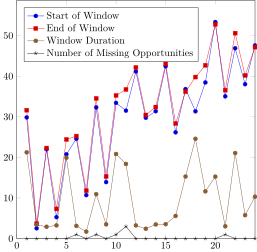

In [5]:
# Plot Differences in Opportunities
Axis([
    Plots.Linear(1:24, sdev_diff[1, :], legendentry="Start of Window")
    Plots.Linear(1:24, sdev_diff[2, :], legendentry="End of Window")
    Plots.Linear(1:24, sdev_diff[3, :], legendentry="Window Duration")
    Plots.Linear(1:24, missing_opportunities, legendentry="Number of Missing Opportunities")
], width="10cm", height="10cm", legendPos="north west", xmin=0, xmax=24, ymin=0)

In [6]:
# Graph planning
@time path, reward, image_list = sp_graph_policy(collects, Function[constraint_agility_single_axis], horizon=0.0, allow_repeats=false)

println("Total planning reward: $reward")
println("Number of images collected: $(length(image_list))/$num_images, $(length(image_list)/num_images*100)")
println("Number of feasible images collected: $(length(image_list))/$num_feasible, $(length(image_list)/num_feasible*100)")

  6.364821 seconds (66.48 M allocations: 2.246 GiB, 11.54% gc time)
Total planning reward: 125.0
Number of images collected: 125/150, 83.33333333333334
Number of feasible images collected: 125/125, 100.0


In [7]:
# MILP planning
@time path, reward, image_list = sp_milp_policy(collects, Function[constraint_agility_single_axis], horizon=0.0, allow_repeats=false)

println("Total planning reward: $reward")
println("Number of images collected: $(length(image_list))/$num_images, $(length(image_list)/num_images*100)")
println("Number of feasible images collected: $(length(image_list))/$num_feasible, $(length(image_list)/num_feasible*100)")

Academic license - for non-commercial use only
Optimize a model with 52931 rows, 4635 columns and 110247 nonzeros
Variable types: 0 continuous, 4635 integer (4635 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Variable types: 0 continuous, 4635 integer (4635 binary)

Root relaxation: objective 1.250000e+02, 31 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                     125.0000000 4635.00000  3608%     -    0s
     0     0          -    0       125.00000  125.00000  0.00%     -    0s

Explored 0 nodes (92 simplex iterations) in 0.13 seconds
Thread count was 12 (of 12 available processors)

Solution count 1: 125 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.250000000000e+02, best bound 1.250000000000e+02

In [8]:
# MDP Planning
@time path, reward, image_list = sp_mdp_policy(collects, Function[constraint_agility_single_axis], horizon=0.0, allow_repeats=false)

println("Total planning reward: $reward")
println("Number of images collected: $(length(image_list))/$num_images, $(length(image_list)/num_images*100)")
println("Number of feasible images collected: $(length(image_list))/$num_feasible, $(length(image_list)/num_feasible*100)")

164.816916 seconds (43.44 M allocations: 1.611 GiB, 0.46% gc time)
Total planning reward: Collect(Ptr: 4744780608, Orbit: 0, Image: 4744592112, Opportunity: 4706806256, Start: Epoch(2019-01-01T00:09:39.000Z), End: Epoch(2019-01-01T00:09:44.000Z))
Number of images collected: 124/150, 82.66666666666667
Number of feasible images collected: 124/125, 99.2
